In [2]:
from game_board import GameBoard
from game_state import Player, GameState, QMap
from strateegery import Strateegery

from time import time
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import pickle

from play import LearningPlayer, setupGame, getRatios, fightDuels, playGames, trainQ, graphStats, printTally
%matplotlib inline

Data Exploration/Visualization
--------------------

**Approximate baseline win/draw/loss ratios using random policy:**

On the cell bellow the proportions of the actual game counts for 3x3 tictactoe, i.e;  

91/138 : 3/138 : 44/138

are compared to the simulated ratios:  

(total # player 1 wins)/10000 : (total # draws)/10000 : (total # player 2 wins)/10000  

As noted on the report the proportion of draws increases with size of the game.

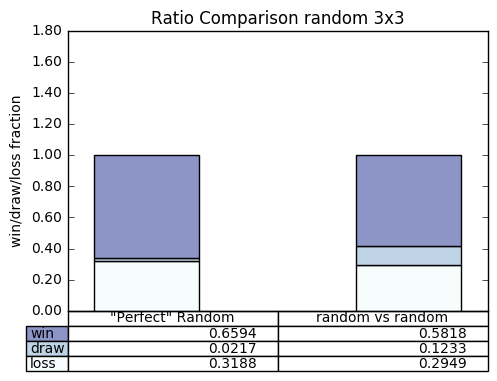

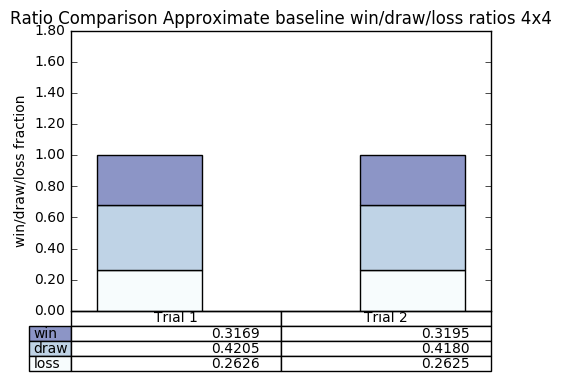

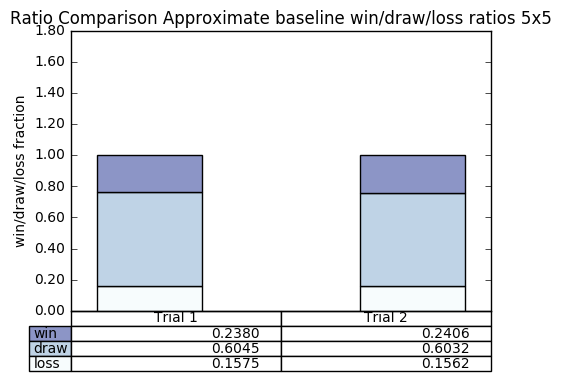

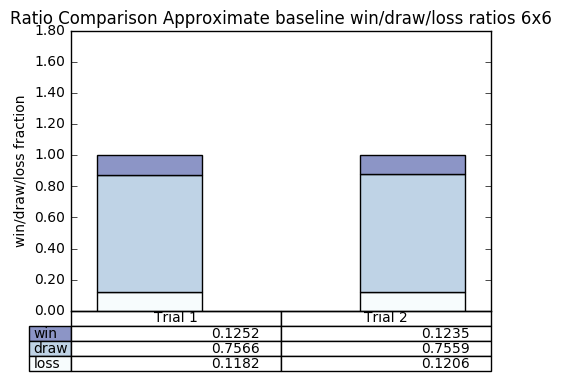

In [4]:
###############################################################
# Approximate baseline win/draw/loss ratios using random policy

if __name__ == '__main__': 
    size = 3
    columns  = ('"Perfect" Random', 'random vs random')
    
    # TicTacToe X-O win/loss/draw ratio: 91:44:3 or 0.6594 : 0.31884 : 0.0217, source wikipedia
    ratios = [[44.0/138, 3.0/138, 91.0/138 ]]
    ratios += fightDuels([QMap()], [['random', 'random']], size, n_games = 10000)

    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'random 3x3')

    ##
    size = 4
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 4x4')

    ## 
    size = 5
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 5x5')

    ##
    size = 6
    columns = ('Trial 1', 'Trial 2')
    ratios = np.transpose(fightDuels([QMap(), QMap()], [ ['random','random'], ['random','random'] ], size, 10000))

    graphStats(columns, ratios, 'Approximate baseline win/draw/loss ratios 6x6')

Algorithms and Techniques
----------------------------

**Ideal policy baseline comparison**

The ratios of actual counts of a non-losing player wins to draws of 3x3 tictactoe i.e.;

91/94 : 3/94 as player 1 
44/47 : 3/47 as player 2

Are compared to 1000 games of the Ideal policy vs random, both as player 1 and player 2. As discussed in the  
report, Ideal tends to be stronger than expected as player 1 and weaker than expected as player 2. However in
never loses.

4.84890604019


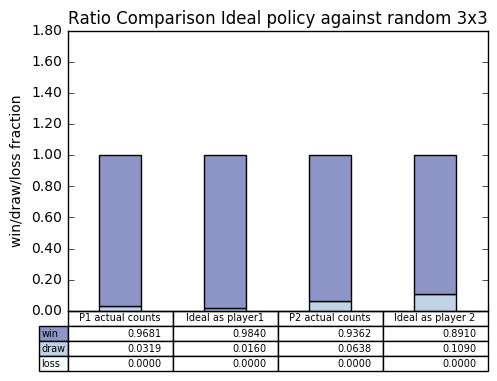

In [4]:
#########################
# Ideal policy stats 3x3
if __name__ == '__main__':  
    size = 3
    start = time()
    columns  = ('P1 actual counts', 'Ideal as player1', 'P2 actual counts', 'Ideal as player 2')

    # Perfect X player 3x3 win/draw/loss ratio 91:3:0 or 0.9681 : 0.0319 : 0  
    ratios = [[ 0/94, 3.0/94, 91.0/94]]
    ratios += fightDuels([QMap()], [['ideal', 'random']], size, n_games = 1000)

    # Perfect O player 3x3 win/draw/loss ratio 0:3:44 or 0.9363 :0.0638 : 0
    ratios.append([ 0/47, 3.0/47, 44.0/47 ])
    
    # This guy needs to be reversed because we are interested in player2 wins
    ratios.append(fightDuels([QMap()], [['random', 'ideal']], size, n_games = 1000)[0][::-1] )
    
    print time() - start
    graphStats(columns, np.transpose(ratios), 'Ideal policy against random 3x3')
    

**Minimax policy baseline comparison**

The ratios of actual counts of a non-losing player wins to draws of 3x3 tictactoe i.e.;

91/94 : 3/94 as player 1 
44/47 : 3/47 as player 2

Are compared to 500 games of the minimax policy vs random, both as player 1 and player 2. Minimax as player 1  
is closer to the expected ratio, and similarly to Ideal shows more weakness than expected as player 2. It also  
suffers a small number of losses as player 2, but as described in the report this is most likely an implementation  
failure since it must be run at an exploration depth of 2 to keep its running time reasonable.

86.6210079193


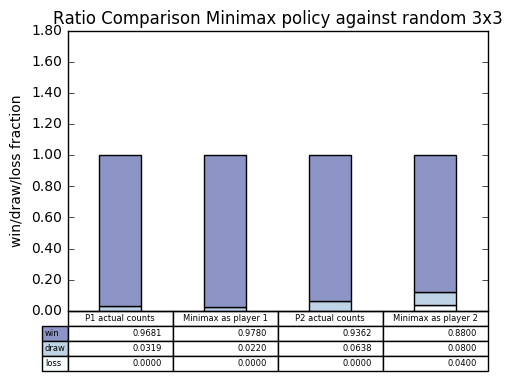

In [8]:
###########################
# Minimax policy stats 3x3

if __name__ == '__main__':
    size = 3
    columns  = ('P1 actual counts', 'Minimax as player 1', 'P2 actual counts', 'Minimax as player 2')
    start = time()
    # Perfect X player 3x3 win/draw/loss ratio 91:3:0 or 0.9681 : 0.0319 : 0  
    ratios  = [[ 0/94, 3.0/94, 91.0/94]]
    ratios += fightDuels([QMap()], [['minimax', 'random']], size, n_games = 500)
         
    # Perfect O player 3x3 win/draw/loss ratio 0:3:44 or 0.9363 :0.0638 : 0
    ratios.append([ 0/47, 3.0/47, 44.0/47 ])

    # This guy needs to be reversed because we are interested in player2 wins
    ratios.append(fightDuels([QMap()], [['random', 'minimax']], size, n_games = 500)[0][::-1])
    
    print time() - start        
    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'Minimax policy against random 3x3')

CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0
43.8427410126


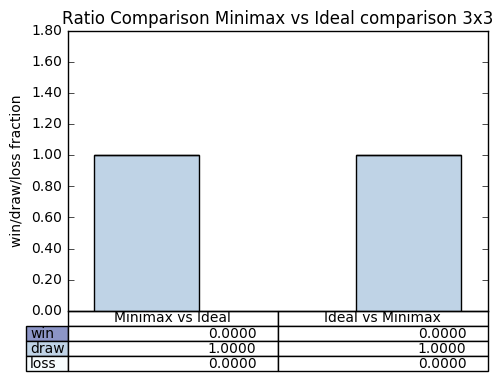

In [19]:
###########################
# Minimax vs Ideal

if __name__ == '__main__': 
    size = 3
    columns  = ('Minimax vs Ideal', 'Ideal vs Minimax')
    start = time()
    ratios = fightDuels([QMap(), QMap()], [['minimax', 'ideal'],
                                           ['ideal', 'minimax'] ], size, n_games = 3, p1qds = [5 , 2], p2ds = [2, 5])
    
    print time() - start        
    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'Minimax vs Ideal comparison 3x3')

Lucky_Q doing its thing

Methodology 
-------------

In [10]:
################################################
# "lucky" Q-learning  vs Ideal and minimax stats

if __name__ == '__main__':  
    size = 3
    with open("../lucky_3x3_Q.pickle", 'rb') as f:
        QM = pickle.load(f)      
        
    #columns  = ('Ideal vs lucky_Q', 'lucky_Q vs Ideal', 'random vs Ideal', 'Ideal vs random')
    
    ratios = fightDuels([QM, QM, QM, QM, QMap()],
                        [ ['ideal', 'Qlearning'  ],
                          ['Qlearning', 'ideal'  ],
                          ['minimax', 'Qlearning'],
                          ['Qlearning', 'minimax'],
                          ['random', 'random'    ]], size, n_games = 100 )
 
    
    cols = ["P1 win",  "draw", "P1 loss"]
    
    rows = ('ideal vs lucky_Q', 'lucky_Q vs ideal',
            'minimax vs lucky_Q', 'lucky_Q vs minimax',
            'random vs random')
    
    table = pd.DataFrame([row[::-1] for row in ratios], columns = cols, index = rows)
    print
    print "Total time: ", time() - start
    display(table)
    
    #ratios = np.transpose(ratios)
    #graphStats(columns, ratios, 'lucky-Q vs Minimax {}x{}'.format(size,size))

CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0

Total time:  1928.91175318


,P1 win,draw,P1 loss
ideal vs lucky_Q,0.99,0.01,0.00
lucky_Q vs ideal,0.00,1.00,0.00
minimax vs lucky_Q,0.85,0.15,0.00
lucky_Q vs minimax,0.00,1.00,0.00
random vs random,0.56,0.09,0.35


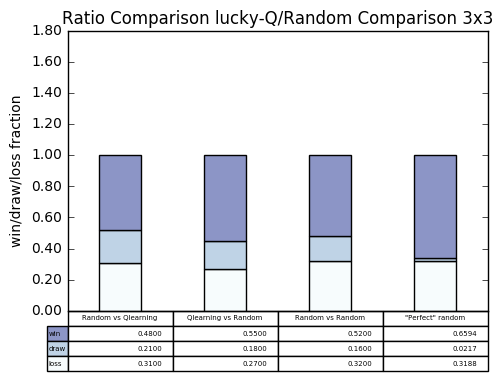

In [18]:
##################################
# "lucky" Q-learn vs Random stats 
    
if __name__ == '__main__':  
     
    columns  = ('Random vs Qlearning',  'Qlearning vs Random', 'Random vs Random', '"Perfect" random')
    
    duels = fightDuels([QM, QMap(), QMap()], [ ['random', 'Qlearning'],
                                               ['Qlearning', 'random'],
                                               ['random', 'random' ]  ], size, n_games = 100, p1ds = [2,3,2], p2ds = [3,2,2] )
    duels.append([44.0/138, 3.0/138, 91.0/138 ])
    ratios = np.transpose(duels)
    
    graphStats(columns, ratios, 'lucky-Q/Random Comparison {}x{}'.format(size,size))

**Lucky's revenge**  

Here a Q is trained from scratch as described in the report with, 70 trials of random vs random games  
followed by 1000 of Qlearning vs random, and then 1000 of random vs Qlearning. The small tally of 30  
games that immediately follows, is simply to observe how Q together with Qlearning strategy, by itself  
stands up to Ideal and minimax. Some Q's come out stronger than others in this regard. Also as described 
in the report, the issues I have had with random seeding are especially evident when using the notebook. 
Even though a seed has been fixed, the results of the cell below are not consistent over runs. However
this exact code is also inside the run method inside the play module, where it can be run with more 
consistent behavior. A big difference in that regard is that the Q produced when not run in the notebook
ties _both_ minimax and Ideal when used as miniQmax.

Training time:  53.47574687
Q using just Qlearning policy


,P1 win,P1 loss,draw
Qlearning v ideal,0,27,3
Qlearning v minimax,0,27,3
Qlearning v Qlearning,6,8,16



CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0
CONVERGENCE ON GAME NUMBER:  0

Total time:  114.812439919


,P1 win,draw,P1 loss
Qlearning vs miniQmax,0.02,0.09,0.89
miniQmax vs Qlearn,0.00,0.71,0.29
minimax vs miniQmax,0.00,1.00,0.00
miniQmax vs minimax,0.00,0.00,1.00
miniQmax vs Ideal,0.00,0.00,1.00
Ideal vs miniQmax,1.00,0.00,0.00


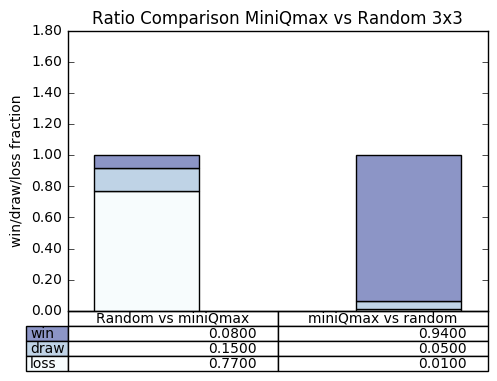

In [13]:
########################
# MiniQmax Comparisons 
if __name__ == '__main__':  
    size = 3
    ts = [70, 1000, 1000, 1000]
    start = time() 
    QM, tally, conv = playGames(setupGame(QMap(), size, ['random', 'random'],  learning=True), ts[0])   
    # player 2 learning against a random player 1
    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'random'],   learning=True), ts[1])   
    # Now player 1 learning against a random player 2
    QM, tally, conv = playGames(setupGame(QM, size, ['random', 'Qlearning'],   learning=True), ts[2])    
    # Have two agents learn against each other
    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'Qlearning'],learning=True), ts[3])
    print "Training time: " , time() - start 

    ## Observe quality of Q (does't it force at least some ties on perfect players?)
    tallies = []
    lbls = [ ('P1 win', (True, False) ), ('P1 loss', (False, True) ), ('draw', (False, False) )]
    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'ideal']), 30, check_convergence = False)
    tallies.append([tally[l[1]] for l in lbls])

    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'minimax']), 30, check_convergence = False)
    tallies.append([tally[l[1]] for l in lbls])

    QM, tally, conv = playGames(setupGame(QM, size, ['Qlearning', 'Qlearning']), 30, check_convergence = False)
    tallies.append([tally[l[1]] for l in lbls])

    quality_table = pd.DataFrame(tallies, columns=[l[0] for l in lbls],
                                 index = ['Qlearning v ideal', 'Qlearning v minimax', 'Qlearning v Qlearning'])
    
    print "Q using just Qlearning policy"
    display(quality_table)
    print

    #######################
    # MiniQmax stats table
    ratios  = fightDuels([QM, QM], [ ['Qlearning', 'miniQmax'],
                                     ['miniQmax', 'Qlearning'] ], size, n_games = 100, p1ds = [2,3], p2ds = [3,2] )[::-1]

    ratios += fightDuels([QM, QM], [ ['minimax', 'miniQmax' ],
                                     ['miniQmax', 'minimax' ] ], size, n_games = 10,  p1ds = [2,3], p2ds = [3,2] )[::-1]

    ratios += fightDuels([QM, QM], [ ['miniQmax', 'ideal'],
                                     ['ideal', 'miniQmax'] ], size, n_games = 100, p1ds = [2,3], p2ds = [3,2] )[::-1]
    
    cols = ["P1 win",  "draw", "P1 loss"]
    
    rows = ('Qlearning vs miniQmax', 'miniQmax vs Qlearn',
            'minimax vs miniQmax', 'miniQmax vs minimax',
            'miniQmax vs Ideal', 'Ideal vs miniQmax')
    
    table = pd.DataFrame(ratios, columns = cols, index = rows)
    print
    print "Total time: ", time() - start
    display(table)

    ## Comparison with random
    columns = ('Random vs miniQmax', 'miniQmax vs random')
    ratios  = fightDuels([QM, QM], [ ['random', 'miniQmax' ],
                                     ['miniQmax', 'random' ] ], size, n_games = 100 , p1ds = [2,3], p2ds = [3,2] )
    ratios = np.transpose(ratios)
    graphStats(columns, ratios, 'MiniQmax vs Random {}x{}'.format(size,size))